In [5]:
from walidacja_funkcji import *
import torch
import torch.nn as nn
import torch.optim as optim
from scipy import stats

In [6]:
def reinit_model(model):
    """Reinicjalizuje wagi modelu"""
    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            nn.init.xavier_uniform_(layer.weight)
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)

def fast_kl_jsd_2d(real_data, fake_data, bins=50):
    all_data = np.vstack([real_data, fake_data])
    range_2d = [(all_data[:, i].min(), all_data[:, i].max()) for i in range(all_data.shape[1])]
    
    # Histogramy w jednej operacji
    P, _ = np.histogramdd(real_data, bins=bins, range=range_2d, density=True)
    Q, _ = np.histogramdd(fake_data, bins=bins, range=range_2d, density=True)
    
    # Normalizacja do prawdopodobieństw
    P = P / P.sum()
    Q = Q / Q.sum()
    
    # Epsilon dla stabilności numerycznej
    epsilon = 1e-8
    P += epsilon
    Q += epsilon
    
    # KL divergence: KL(Q||P) - fake vs real
    kl_divergence = np.sum(Q * np.log(Q / P))
    
    # JSD: 0.5 * [KL(P||M) + KL(Q||M)], gdzie M = (P+Q)/2
    M = (P + Q) / 2 + epsilon
    
    kl_pm = np.sum(P * np.log(P / M))
    kl_qm = np.sum(Q * np.log(Q / M))
    jsd = 0.5 * (kl_pm + kl_qm)
    
    return kl_divergence, jsd

In [80]:
prober = rs_prober_NKG(epsilon=0.1, looking_x_left=-1, looking_x_right=1, from_x=0)

def get_2d_data(PROBE_SIZE: int):
    rs = prober.rejection_sampling(length=PROBE_SIZE // 2)
    theta = np.random.uniform(0, 2*np.pi, size=PROBE_SIZE // 2)
    xs = rs * np.cos(theta)
    ys = rs * np.sin(theta)
    return np.vstack([xs, ys])

In [127]:
def plot_basic_stats(generator_losses, discriminator_losses, KL, JSD, Wasserstein_distance, epoch, extra_label=''):
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(15, 15))
    SAMPLE_LENGTH = GENERATOR_SAMPLES_TO_RETURN * 1000
    ROI = np.array([[-5, 5], [-5, 5]])
    epoch_range = np.arange(epoch)
    markersize = min(4500 / len(epoch_range), 10)
    
    gen_color = '#1f77b4'     # Matplotlib blue
    disc_color = '#d62728'    # Matplotlib red
    x_color = '#ff7f0e'       # Matplotlib orange
    y_color = '#2ca02c'       # Matplotlib green
    theory = '#9467bd'        # Matplotlib purple

    # Get data
    x_true, y_true = get_2d_data(SAMPLE_LENGTH)
    noise = torch.randn(SAMPLE_LENGTH // GENERATOR_SAMPLES_TO_RETURN, NOISE_SIZE).cuda()
    print(f'{noise.shape=}')
    x_fake, y_fake = generator.layers(noise).detach().reshape(-1, 2).cpu().numpy().T

    # Histograms
    hist_true, _, _ = np.histogram2d(x_true, y_true, bins=500, range=ROI)
    hist_fake, _, _ = np.histogram2d(x_fake, y_fake, bins=500, range=ROI)
    
    # Plot 1-2: 2D histograms
    for ax, hist, title in [(ax1, hist_fake, 'Generator'), (ax2, hist_true, 'NKG Metropolis')]:
        im = ax.imshow(np.log10(hist + 1).T, extent=ROI.flatten(), aspect='auto')
        ax.set_title(f'$log_{{10}}$(Liczby czastek) dla {title}')
        ax.set_xlabel('x [m]')
        ax.set_ylabel('y [m]')
        plt.colorbar(im, ax=ax)

    # Plot 3: Losses
    ax3.set_title(f'Logarytm strat, lr_gen={generator.optim.param_groups[0]["lr"]:.2e}\n lr_dis={discriminator.optim.param_groups[0]["lr"]:.2e}')
    ax3.plot(epoch_range, np.log10(discriminator_losses[:epoch] + 1e-12), 'o', markersize=markersize, label='dyskryminator', color=disc_color)
    ax3.plot(epoch_range, np.log10(generator_losses[:epoch] + 1e-12), 'o', markersize=markersize, label='generator', color=gen_color)
    ax3.legend(markerscale=1.5/markersize)
    ax3.set_xlabel('Epoka')
    ax3.set_ylabel(r'$log_{10}$(strata)')
    
    # Plot 4: KL, JSD, Wasserstein
    ax4.set_title('Metryki rozbieznosci')
    ax4.plot(epoch_range, np.log10(Wasserstein_distance[:epoch] + 1e-12), 'o', markersize=markersize, color='green', label='Wasserstein')
    ax4.plot(epoch_range, np.log10(KL[:epoch] + 1e-12), 'o', markersize=markersize, color='blue', label='KL')
    ax4_twin = ax4.twinx()
    ax4_twin.plot(epoch_range, np.log10(JSD[:epoch] + 1e-12), 'o', markersize=markersize, color='red', label='JSD')
    ax4.set_ylabel('$log_{10}$(KL, Wasserstein)', color='blue')
    ax4_twin.set_ylabel('$log_{10}$(JSD)', color='red')
    ax4.set_xlabel('Epoka')
    ax4.legend(markerscale=1.5/markersize, loc='upper left')
    ax4_twin.legend(markerscale=1.5/markersize, loc='upper right')

    # Plot 5: R distribution
    r_true, r_fake = np.sqrt(x_true**2 + y_true**2), np.sqrt(x_fake**2 + y_fake**2)
    r_bins = np.linspace(r_true.min(), r_true.max(), 100)
    ax5.hist(r_true, bins=r_bins, label='Rejection sampling', color=theory, alpha=0.7, edgecolor='white', linewidth=0.5)
    ax5.hist(r_fake, bins=r_bins, label='Generator', alpha=0.6, color=gen_color, edgecolor='white', linewidth=0.5)
    ax5.set_title('Rozklad r')
    ax5.set_xlabel('r [m]')
    ax5.set_ylabel('Liczba probek')
    ax5.legend()

    # Plot 6: X,Y distributions
    bins = np.linspace(-5, 5, 100)
    ax6.hist(x_fake, bins=bins, label=r'$x_{Fake}$', alpha=0.8, color=x_color, edgecolor='white', linewidth=0.5)
    ax6.hist(y_fake, bins=bins, label=r'$y_{Fake}$', alpha=0.6, color=y_color, edgecolor='white', linewidth=0.5)
    ax6.hist(x_true, bins=bins, label=r'$x_{True}$', alpha=0.4, color=theory, edgecolor='white', linewidth=0.5)
    ax6.hist(y_true, bins=bins, label=r'$y_{True}$', alpha=0.3, color='#8B4513', edgecolor='white', linewidth=0.5)  # Saddle Brown zamiast czarnego
    ax6.set_xlabel('Wartosc wspolrzednej x lub y')
    ax6.set_ylabel('Liczba probek')
    ax6.set_title('Rozklady wspolrzednych')
    ax6.legend()

    # Plot 7: Kurtosis
    # theory_kurt = [stats.kurtosis(x_true)] * 2
    # ax7.plot(epoch_range, x_kurtosis_history[:epoch], 'o', markersize=markersize, label=r'$\kappa_x$', color=x_color)
    # ax7.plot(epoch_range, y_kurtosis_history[:epoch], 'o', markersize=markersize, label=r'$\kappa_y$', color=y_color)
    # ax7.plot([0, epoch_range[-1]], theory_kurt, linewidth=1, label='teoria', color=theory)
    # ax7.set_title('Kurtoza')
    # ax7.set_xlabel('Epoka')
    # ax7.set_ylabel('Wartosc kurtozy')
    # ax7.legend(markerscale=1.5/markersize)

    # Plot 8: Standard deviation
    theory_std = [np.std(x_true)] * 2
    ax7.plot(epoch_range, x_stdev_history[:epoch], 'o', markersize=markersize, label=r'$\sigma_x$', color=x_color)
    ax7.plot(epoch_range, y_stdev_history[:epoch], 'o', markersize=markersize, label=r'$\sigma_y$', color=y_color)
    ax7.plot([0, epoch_range[-1]], theory_std, linewidth=1, label='teoria', color=theory)
    ax7.set_title('Odchylenie standardowe')
    ax7.set_ylabel(r'Wartosc $\sigma$')
    ax7.set_xlabel('Epoka')
    ax7.set_ylim([0, min(max(x_stdev_history[:epoch].max(), y_stdev_history[:epoch].max()), 3*theory_std[0])])
    ax7.legend(markerscale=1.5/markersize)

    # Plot 9: Weight changes
    ax8.plot(discriminator_weights_change[:epoch], 'o', markersize=markersize, label='Dyskryminator', color=disc_color)
    ax8.plot(generator_weights_change[:epoch], 'o', markersize=markersize, label='Generator', color=gen_color)
    ax8.set_title('Zmiany wag')
    ax8.set_xlabel('Epoka')
    ax8.set_ylabel(r'Zmiana')
    ax8.legend()
    
    # Plot 10: srednia kwadratow
    theoretical_x2 = [np.mean(x_true[:epoch] ** 2)]
    ax9.plot(epoch_range, x_skewness_history[:epoch], 'o', markersize=markersize, label=r'Skew_{G, x}')
    ax9.plot(epoch_range, x_skewness_history[:epoch], 'o', markersize=markersize, label=r'Skew_{G, y}')
    ax9.plot(epoch_range, theoretical_x2 * epoch, 'o', markersize=markersize, label='Wartosc teroretyczna')
    ax9.set_title('Porownanie skosnosci')
    ax9.set_ylabel('Skosnosc')
    ax9.set_xlabel('Epoka')
    ax9.legend()

    print(f'{r_true.shape=}, {r_fake.shape=}')

    # Statistics
    r_pearson = np.log10(1 - np.corrcoef(np.sort(r_true), np.sort(r_fake))[0, 1])
    x_pearson = np.log10(1 - np.corrcoef(np.sort(x_true), np.sort(x_fake))[0, 1])
    y_pearson = np.log10(1 - np.corrcoef(np.sort(y_true), np.sort(y_fake))[0, 1])

    # Fixed text positioning - move higher to avoid cutting
    fig.text(0.5, 0.97, f'{EPOCHS=}, {LR_CONSTANT=}, {LR_RATIO=}, {BATCH_SIZE=}', ha='center', fontsize=16)
    fig.text(0.5, 0.945, f'{GENERATOR_SAMPLES_TO_RETURN=}', ha='center', fontsize=16)
    fig.text(0.5, 0.92, rf'$log_{{10}}$(1-$\rho_{{r, Pearson}}$) = {r_pearson:.3f}, $log_{{10}}$(1-$\rho_{{x, Pearson}}$) = {x_pearson:.3f}, $log_{{10}}$(1-$\rho_{{y, Pearson}}$) = {y_pearson:.3f}', ha='center', fontsize=16)
    
    # Adjust layout with proper spacing for text
    plt.tight_layout(rect=[0, 0.02, 1, 0.91])  # Leave more space at top
    plt.savefig(f'./Wykresy/Moj_NKG/podsumowanie{extra_label}.jpg', dpi=150, bbox_inches='tight')

print(f'{generator_layers}')
# plot_basic_stats(generator_losses, discriminator_losses, KL, JSD, Wasserstein_distance, EPOCHS, f'\nTrening_dla_{EPOCHS=}')

[Linear(in_features=288, out_features=288, bias=True), LeakyReLU(negative_slope=0.2), Linear(in_features=288, out_features=329, bias=True), LeakyReLU(negative_slope=0.2), Linear(in_features=329, out_features=370, bias=True), LeakyReLU(negative_slope=0.2), Linear(in_features=370, out_features=411, bias=True), LeakyReLU(negative_slope=0.2), Linear(in_features=411, out_features=452, bias=True), LeakyReLU(negative_slope=0.2), Linear(in_features=452, out_features=493, bias=True), LeakyReLU(negative_slope=0.2), Linear(in_features=493, out_features=534, bias=True), LeakyReLU(negative_slope=0.2)]


In [ ]:
"""
    Generator z szumu bedzie dawac x i y - ale czy ja powinienem mu przeslac informacje o zakresie w jakim ma generowac x ?
"""

class Generator(nn.Module):
    def __init__(self, layers: list, lr: float = 1e-5):
        super().__init__()
        self.layers = nn.Sequential(*layers)
        self.optim = optim.Adam(self.parameters(), lr, betas=(0.5, 0.999))
        self.loss = nn.BCEWithLogitsLoss()
        self = self.to('cuda')

    def training_step(self, noise): # OPTIMIZE - would be nice to send here the data - instead of generating it
        self.zero_grad()
        fake_data = generator.layers(noise).reshape(BATCH_SIZE, -1, 2).cpu()
        fake_histogram = make_histogram(fake_data, min_value=-30, max_value=30, bins=60).cuda()
        fake_labels = discriminator.layers(fake_histogram)
        gen_loss = self.loss(fake_labels, torch.ones_like(fake_labels))
        gen_loss.backward()
        gen_loss = gen_loss.detach().item()
        self.optim.step()
        return gen_loss

In [ ]:
"""
    Dyskriminator tak jak zwykle bierze input i zwraca czy prawdziwy czy nie
"""

class Discriminator(nn.Module):
    def __init__(self, layers: list, lr: float = 1e-5):
        super().__init__()
        self.layers = nn.Sequential(*layers)
        self.optim = optim.Adam(self.parameters(), lr, betas=(0.5, 0.999))
        self.loss = nn.BCEWithLogitsLoss()
        self = self.to('cuda')

    def training_step(self, true_histogram, fake_histogram, steps = 1):
        for _ in range(steps):
            self.optim.zero_grad()
            y_true = self.layers(true_histogram)
            loss_true = self.loss(y_true, torch.ones_like(y_true).cuda())

            y_fake = self.layers(fake_histogram)
            loss_fake = self.loss(y_fake, torch.zeros_like(y_fake).cuda())

            loss = (loss_true + loss_fake)

            loss.backward()
            loss = loss.detach().item()
            self.optim.step()
        
        return loss

In [144]:
from concurrent.futures import ThreadPoolExecutor
import time

# Konfiguracja
EPOCHS = 5_000 #* 2000 epok / min
LR_CONSTANT = 5e-3
LR_RATIO = 0.01 # LR_DYSKR / LR_GEN
BATCH_SIZE = 128
NOISE_SIZE = 288
GENERATOR_SAMPLES_TO_RETURN = 134

LOSS_RATIO = 5
LR_SCALE_VALUE = 1.01

for LR_RATIO in 10 ** np.linspace(-2, 0, num=5):
    torch.manual_seed(42)
    np.random.seed(42)

    x_kurtosis_history, y_kurtosis_history  = np.empty(EPOCHS), np.empty(EPOCHS)
    x_skewness_history, y_skewness_history  = np.empty(EPOCHS), np.empty(EPOCHS)
    x_stdev_history, y_stdev_history        = np.empty(EPOCHS), np.empty(EPOCHS)
    x2_mean_history, y2_mean_history        = np.empty(EPOCHS), np.empty(EPOCHS)
    generator_losses, discriminator_losses  = np.empty(EPOCHS), np.empty(EPOCHS)
    KL, JSD, Wasserstein_distance           = np.empty(EPOCHS), np.empty(EPOCHS), np.empty(EPOCHS)
    G_weight_change, D_weight_change        = np.empty(EPOCHS), np.empty(EPOCHS)

    # transposed:  (Input_size - 1) × Stride - 2×Padding + Kernel_size + Output_padding
    LAYERS_NUM = 7
    INCREMENT_GENERATOR = (GENERATOR_SAMPLES_TO_RETURN - NOISE_SIZE) / LAYERS_NUM
    generator_layers = [
        layer
        for i in range(LAYERS_NUM)
        for layer in [nn.LazyLinear(int(NOISE_SIZE + (i+1) * INCREMENT_GENERATOR)), nn.LeakyReLU(negative_slope=0.2)]
    ]
    generator = Generator(generator_layers, LR_CONSTANT)

    # convolution: floor((Input_size + 2×Padding - Kernel_size) / Stride) + 1
    INCREMENT_DISCRIMINATOR = (GENERATOR_SAMPLES_TO_RETURN - 1) // LAYERS_NUM
    discriminator_layers = [ # histogram is going in
        layer
        for i in range(LAYERS_NUM)
        for layer in [nn.LazyLinear(int(NOISE_SIZE + (i+1) * INCREMENT_GENERATOR)), nn.LeakyReLU(negative_slope=0.2)]
    ]
    discriminator_layers.extend( [nn.LazyLinear(1)] )
    discriminator = Discriminator(discriminator_layers, LR_CONSTANT * LR_RATIO)

    generator.train()
    generator.compile()
    discriminator.train()
    discriminator.compile()


    def add_stats(data_tensor: torch.Tensor, epoch: int = None):
        tensor_view = data_tensor.view(BATCH_SIZE, -1, 2)
        means = tensor_view.mean(dim=1)  # (batch, 2)
        stds = tensor_view.std(dim=1)    # (batch, 2)
        squared_mean = torch.pow(tensor_view, 2).mean(dim=1)

        normalized = (tensor_view - means.unsqueeze(1)) / stds.unsqueeze(1)

        skewness = torch.pow(normalized, 3).mean(dim=1)
        kurtosis = torch.pow(normalized, 4).mean(dim=1) - 3

        if epoch is not None:
            x_kurtosis_history[epoch],  y_kurtosis_history[epoch]   = kurtosis.mean(dim=0).cpu().numpy()
            x_skewness_history[epoch],  y_skewness_history[epoch]   = skewness.mean(dim=0).cpu().numpy()
            x2_mean_history[epoch],     y2_mean_history[epoch]      = squared_mean.mean(dim=0).cpu().numpy()
            x_stdev_history[epoch],     y_stdev_history[epoch]      = stds.mean(dim=0).cpu().numpy()


    def gather_stats(true_data, fake_data, epoch):
        true_data_np = true_data.reshape(-1, 1).cpu().detach().numpy()
        fake_data_np = fake_data.reshape(-1, 1).cpu().detach().numpy()

        progress = epoch / EPOCHS
        filled = int(200 * progress)
        bar = '█' * filled + '░' * (200 - filled)
        print(f'\rTrening [{bar}] ({progress*100:5.1f}%)', end='', flush=True)

        KL[epoch], JSD[epoch] = fast_kl_jsd_2d(true_data_np, fake_data_np)
        Wasserstein_distance[epoch] = stats.wasserstein_distance(fake_data_np.reshape(-1,), true_data_np.reshape(-1,))

        if epoch % 1_000 == 0 and epoch != 0:
            plot_basic_stats(generator_losses, discriminator_losses, KL, JSD, Wasserstein_distance, epoch, f'\nTrening_dla_{LR_RATIO=}_{epoch=}')


    def create_noise_and_data():
        noise = torch.randn(BATCH_SIZE, NOISE_SIZE).cuda()
        data = get_2d_data(BATCH_SIZE * GENERATOR_SAMPLES_TO_RETURN)
        return noise, data


    def calculate_weights(model: nn.Module):
        total_norm = 0.0
        for parameter in model.parameters():
            if parameter.grad is not None: # kiedy mialoby byc None?
                total_norm += parameter.grad.norm(2).item() ** 2

        return total_norm ** 0.5


    def make_histogram(input_tensor: torch.FloatTensor, min_value: float, max_value: float, bins: int = 20):
        bin_width = (max_value - min_value) / bins
        
        x_indices = ((input_tensor[:, :, 0] - min_value) // bin_width).long().clamp(0, bins - 1)
        y_indices = ((input_tensor[:, :, 1] - min_value) // bin_width).long().clamp(0, bins - 1)

        total_bins = BATCH_SIZE * bins * bins

        linear_idx = y_indices * bins + x_indices  # Shape: (BATCH_SIZE, N_points)
        linear_idx += torch.arange(0, total_bins, bins * bins, device=input_tensor.device)[:, None]

        flat_linear_idx = linear_idx.view(-1)
        
        hist_flat = torch.bincount(flat_linear_idx, minlength=total_bins)
        
        histograms = hist_flat.view(BATCH_SIZE, 1, bins, bins).float()
        
        return histograms


    def add_weights(epoch: int):
        G_weight_change[epoch] = calculate_weights(generator)
        D_weight_change[epoch] = calculate_weights(discriminator)

    noise, data = create_noise_and_data()
    lr_scale_discriminator, lr_scale_generator = None, None

    start_time = time.time()
    with ThreadPoolExecutor(max_workers=4) as executor:
        for epoch in range(EPOCHS):
            # start = time.time()
            fake_data = generator.layers(noise).reshape(BATCH_SIZE, -1, 2).detach()
            # print(f'Fake data: {(time.time() - start) * 10**3 :.1f} ms')

            # start = time.time()
            add_stats(fake_data, epoch)
            # print(f'Add stats: {(time.time() - start) * 10**3 :.1f} ms')

            # start = time.time()
            fake_histogram = make_histogram(fake_data, min_value=-30, max_value=30, bins=60)
            # print(f'Make histogram (fake): {(time.time() - start) * 10**3 :.1f} ms')

            true_data = torch.FloatTensor(data).reshape(BATCH_SIZE, -1, 2).cuda()

            # start = time.time()
            add_stats(true_data)
            # print(f'Add stats (true): {(time.time() - start) * 10**3 :.1f} ms')

            # start = time.time()
            true_histogram = make_histogram(true_data, min_value=-30, max_value=30, bins=60)
            # print(f'Make histogram (true): {(time.time() - start) * 10**3 :.1f} ms')

            # start = time.time()
            discriminator_losses[epoch] = discriminator.training_step(true_histogram, fake_histogram)
            # print(f'Discriminator training: {(time.time() - start) * 10**3 :.1f} ms')

            # start = time.time()
            generator_losses[epoch] = generator.training_step(noise)
            # print(f'Generator training: {(time.time() - start) * 10**3 :.1f} ms\n\n')

            future_stats = executor.submit(gather_stats, true_data, fake_data, epoch)
            future_weights = executor.submit(add_weights, epoch)
            noise, data = executor.submit(create_noise_and_data).result()

            # if discriminator_losses[epoch] < LOSS_RATIO * generator_losses[epoch]:
            #     lr_scale_generator = 1. / LR_SCALE_VALUE
            #     lr_scale_discriminator = LR_SCALE_VALUE
            # else:
            #     lr_scale_generator = LR_SCALE_VALUE
            #     lr_scale_discriminator = 1. / LR_SCALE_VALUE

            # for param in generator.optim.param_groups:
            #     param['lr'] *= lr_scale_discriminator
            # for param in discriminator.optim.param_groups:
            #     param['lr'] *= lr_scale_generator


    bar = '█' * 200
    print(f'\rTrening [{bar}] {epoch:4d}/{EPOCHS}\n({100:5.1f}%)\n', end='', flush=True)
    print(f'\n{EPOCHS / (time.time() - start_time) * 60:.0f} Epok / min')

    plot_basic_stats(generator_losses, discriminator_losses, KL, JSD, Wasserstein_distance, EPOCHS, f'\nTrening_dla_{LR_RATIO=}')

Trening [████████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░] (  8.0%)

KeyboardInterrupt: 

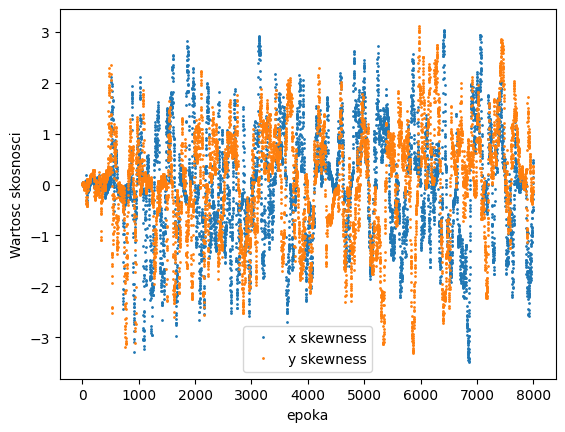

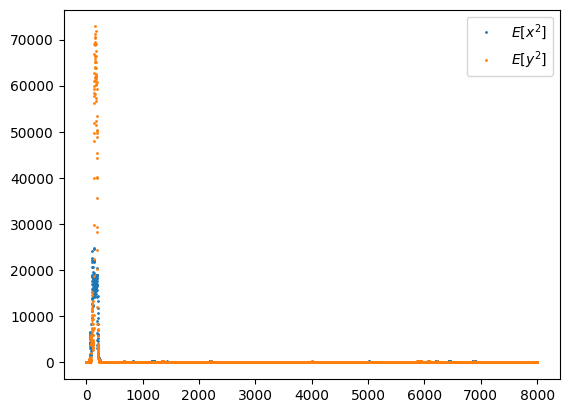

In [85]:
plt.plot(x_skewness_history, 'o', markersize=1, label='x skewness')
plt.plot(y_skewness_history, 'o', markersize=1, label='y skewness')
plt.xlabel('epoka')
plt.ylabel('Wartosc skosnosci')
plt.legend()
plt.show()

plt.plot(x2_mean_history, 'o', markersize=1, label=r'$E[x^2]$')
plt.plot(y2_mean_history, 'o', markersize=1, label=r'$E[y^2]$')
plt.legend()

In [ ]:
plot_basic_stats(generator_losses, discriminator_losses, KL, JSD, '\nNajlepszy model poki co')
torch.save(discriminator.state_dict(), "best_discriminator_so_far.pth")
torch.save(generator.state_dict(), 'best_generator_so_far.pth')

TypeError: plot_basic_stats() missing 2 required positional arguments: 'LR_GAMMA' and 'LR_STEP_SIZE'

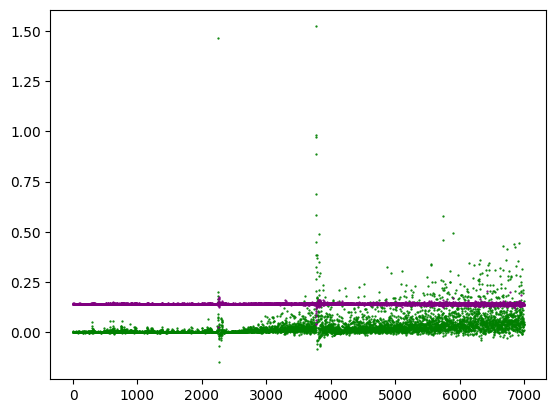

In [ ]:
plt.plot(np.log10( generator_losses[3_000:] ), 'o', markersize=0.6, color='green')
plt.plot(np.log10( discriminator_losses[3_000:] ), 'o', markersize=0.6, color='purple')